In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import datetime

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Enhance IT/Time Series Analizys/Electric_Production.csv')

In [ ]:
df

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [ ]:
df.shape

(397, 2)

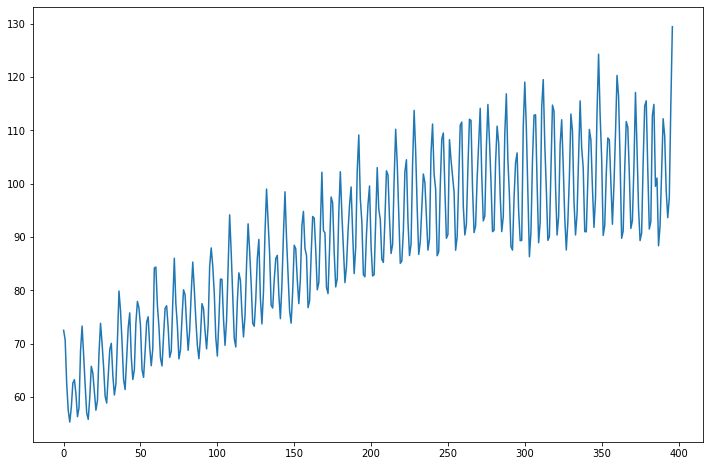

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df.IPG2211A2N)

In [ ]:
df.columns

Index(['DATE', 'IPG2211A2N'], dtype='object')

In [ ]:
df=df.rename(columns={'DATE':'ds', 'IPG2211A2N':'ts'})

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def test_stationarity(df,ts):

  #Rolling statistics 
  rolmean = df[ts].rolling(window=12, center=False).mean()
  rolstd  = df[ts].rolling(window=12, center=False).std()

  #Plot Rolling Stats
  orig = plt.plot(df[ts], color='blue', label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std  = plt.plot(rolstd, color='black', label='Rolling Standard Dev')

  plt.legend(loc='best')
  plt.title('Rolling Mean  Standard Deviation for %s' %(ts))
  plt.xticks(rotation=45)
  plt.show(block = False)
  plt.close()

  dftest = adfuller(df[ts], autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations'])

  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value

  print('Results of Dickey-Fuller Test: ')
  print(dfoutput)


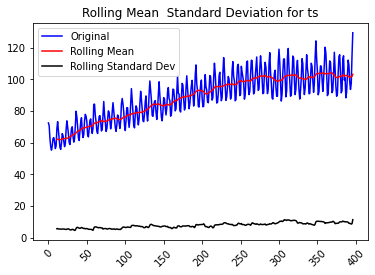

Results of Dickey-Fuller Test: 
Test Statistic             -2.256990
p-value                     0.186215
# Lags Used                15.000000
Number of Observations    381.000000
Critical Value (1%)        -3.447631
Critical Value (5%)        -2.869156
Critical Value (10%)       -2.570827
dtype: float64


In [ ]:
test_stationarity(df=df, ts='ts')

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
decomposition= seasonal_decompose(df['ts'], freq=48, extrapolate_trend=1)

In [ ]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,5), sharex=True)
  
  ax1.plot(df[ts], label='Original')
  ax1.legend(loc='best')
  ax1.tick_params(axis='x', rotation=45)

  ax2.plot(df[trend], label='Trend')
  ax2.legend(loc='best')
  ax2.tick_params(axis='x', rotation=45)

  ax3.plot(df[seasonal], label='Seasonality')
  ax3.legend(loc='best')
  ax3.tick_params(axis='x', rotation=45)

  ax4.plot(df[residual], label='Residuals')
  ax4.legend(loc='best')
  ax4.tick_params(axis='x', rotation=45)
  plt.tight_layout()

  plt.show()


In [ ]:
new_df = df.copy()

In [ ]:
new_df.loc[:, 'trend'] = decomposition.trend
new_df.loc[:, 'seasonal'] = decomposition.seasonal
new_df.loc[:, 'resid'] = decomposition.resid

In [ ]:
new_df

,ds,ts,trend,seasonal,resid
0,1/1/1985,72.5052,62.283490,12.718409,-2.496698
1,2/1/1985,70.6720,62.402488,4.485310,3.784203
2,3/1/1985,62.4502,62.521485,0.002722,-0.074007
3,4/1/1985,57.4714,62.640483,-9.560648,4.391564
4,5/1/1985,55.3151,62.759481,-10.297909,2.853527
...,...,...,...,...,...
392,9/1/2017,98.6154,103.144796,-3.417189,-1.112207
393,10/1/2017,93.6137,103.158323,-9.077678,-0.466945
394,11/1/2017,97.3359,103.171850,-6.452660,0.616710
395,12/1/2017,114.7212,103.185377,7.733419,3.802404


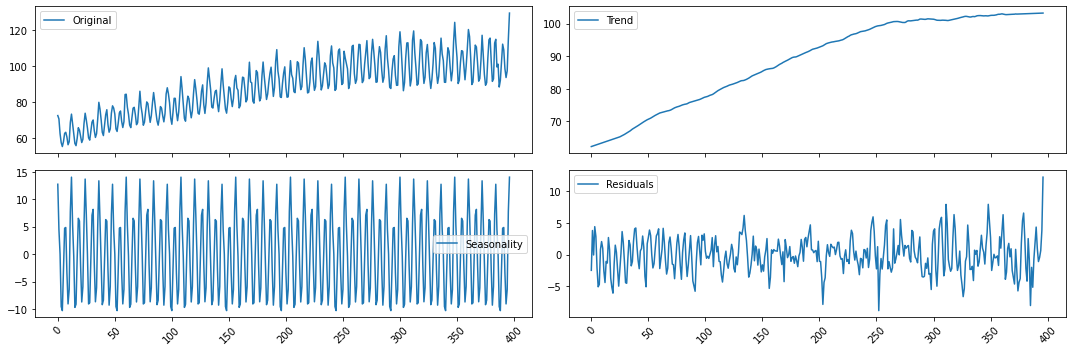

In [ ]:
plot_decomposition(new_df, ts='ts', trend='trend', seasonal='seasonal', residual='resid')

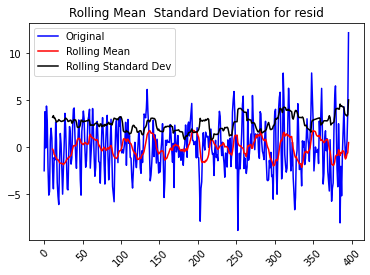

Results of Dickey-Fuller Test: 
Test Statistic             -5.108909
p-value                     0.000013
# Lags Used                16.000000
Number of Observations    380.000000
Critical Value (1%)        -3.447676
Critical Value (5%)        -2.869176
Critical Value (10%)       -2.570838
dtype: float64


In [ ]:
test_stationarity(new_df, 'resid')

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
def run_arima(df,ts, p, d, q):
  
  model  = ARIMA(df[ts], order=(p,d,q))
  results_arima = model.fit(disp=-1)

  len_results = len(results_arima.fittedvalues)
  ts_modified = df[ts][-len_results:]

  rss = sum((results_arima.fittedvalues-ts_modified)**2)
  rmse= np.sqrt(rss/len(df[ts]))
  print('rmse', rmse)

  plt.figure(figsize=(12,8))
  plt.plot(df[ts])
  plt.plot(results_arima.fittedvalues, color='red')

  plt.show()
  return results_arima

In [ ]:
new_df = new_df.fillna(value=0)

rmse 2.0581304903224726


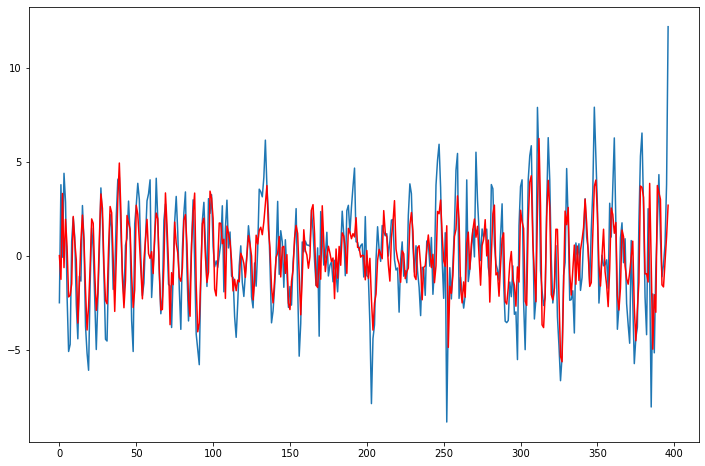

In [ ]:
model_Ar = run_arima(df=new_df, ts='resid', p=15, d=0,q=0)

In [ ]:
my_forecast = model_Ar.forecast(100)

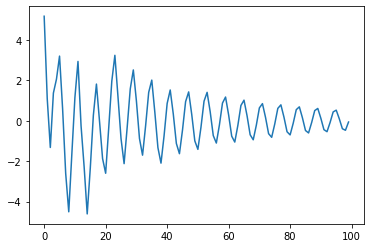

In [ ]:
plt.plot(my_forecast[0])

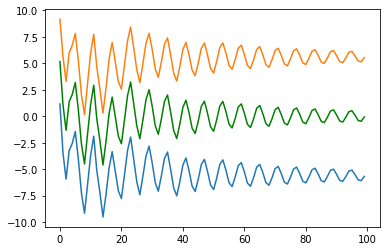

In [ ]:
plt.figure()
plt.plot(my_forecast[0], color='green')
plt.plot(my_forecast[2])

In [ ]:
my_forecast[1]

array([2.04213168, 2.3246141 , 2.35676431, 2.35895386, 2.36195772,
       2.36519441, 2.36767871, 2.36895633, 2.37602018, 2.43970439,
       2.45547064, 2.45556848, 2.49581834, 2.50029353, 2.5007946 ,
       2.56180024, 2.62231082, 2.63140809, 2.63317539, 2.63494512,
       2.6351986 , 2.64627243, 2.64796773, 2.65104488, 2.68512791,
       2.70008737, 2.70039502, 2.71329306, 2.72074888, 2.72082401,
       2.73320461, 2.74381173, 2.74427727, 2.74895822, 2.75097556,
       2.7515264 , 2.76099786, 2.76417541, 2.76497956, 2.77781583,
       2.78572413, 2.78579244, 2.79080799, 2.79426776, 2.79434262,
       2.79970775, 2.8028306 , 2.8028765 , 2.80724958, 2.80927215,
       2.80956998, 2.81477396, 2.81730753, 2.817515  , 2.82249252,
       2.82569418, 2.8256953 , 2.8283635 , 2.82991885, 2.83004858,
       2.83302708, 2.834518  , 2.83465982, 2.83747209, 2.83889192,
       2.83902564, 2.84160129, 2.84297756, 2.84307261, 2.84529939,
       2.84658758, 2.84662852, 2.84822024, 2.8490259 , 2.84914

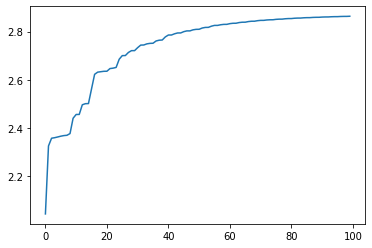

In [ ]:
plt.plot(my_forecast[1])

In [ ]:
my_forecast

(array([ 5.16431977,  1.08343943, -1.32292489,  1.3665387 ,  2.05518824,
         3.19368443,  0.57994037, -2.60756808, -4.50419133, -1.65140549,
         1.14797625,  2.93018904, -0.2547031 , -2.2806805 , -4.60822428,
        -2.34627323,  0.26489832,  1.81082839, -0.01893506, -1.87362048,
        -2.5987296 , -0.35260375,  1.95540736,  3.23300017,  1.2008269 ,
        -0.88372129, -2.12321301, -0.32936653,  1.56870129,  2.50954423,
         0.97947234, -0.88006179, -1.70395382, -0.24539934,  1.40132202,
         2.00736249,  0.41142626, -1.33224876, -2.09769465, -0.74668149,
         0.84977642,  1.51883048,  0.32666914, -1.12502146, -1.63081757,
        -0.45577207,  0.94140534,  1.42353872,  0.30833058, -0.99802902,
        -1.4166204 , -0.32575587,  0.96467134,  1.40146295,  0.44420157,
        -0.73430618, -1.10493476, -0.21177359,  0.87148276,  1.16978252,
         0.28520087, -0.76367179, -1.05566974, -0.23197637,  0.75302934,
         1.01547815,  0.23931461, -0.69570656, -0.9

In [ ]:
from fbprophet import Prophet

In [ ]:
new_df

,ds,ts,trend,seasonal,resid
0,1/1/1985,72.5052,62.283490,12.718409,-2.496698
1,2/1/1985,70.6720,62.402488,4.485310,3.784203
2,3/1/1985,62.4502,62.521485,0.002722,-0.074007
3,4/1/1985,57.4714,62.640483,-9.560648,4.391564
4,5/1/1985,55.3151,62.759481,-10.297909,2.853527
...,...,...,...,...,...
392,9/1/2017,98.6154,103.144796,-3.417189,-1.112207
393,10/1/2017,93.6137,103.158323,-9.077678,-0.466945
394,11/1/2017,97.3359,103.171850,-6.452660,0.616710
395,12/1/2017,114.7212,103.185377,7.733419,3.802404


In [ ]:
new_new_df = new_df.filter(['ds', 'ts'])

In [ ]:
new_new_df.columns = ['ds', 'y']
new_new_df.columns

Index(['ds', 'y'], dtype='object')

In [ ]:
new_new_df['ds'] = pd.to_datetime(new_new_df['ds'], dayfirst=False)

In [ ]:
model = Prophet(changepoint_prior_scale=2)
model.fit(new_new_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_data = model.make_future_dataframe(periods=100)

In [ ]:
forecast_data = model.predict(future_data)

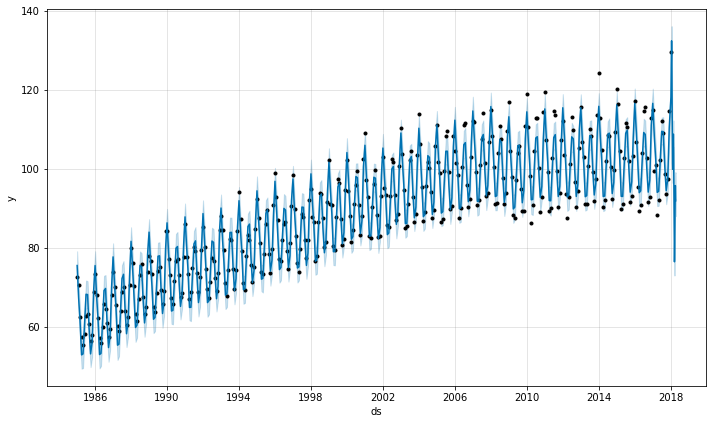

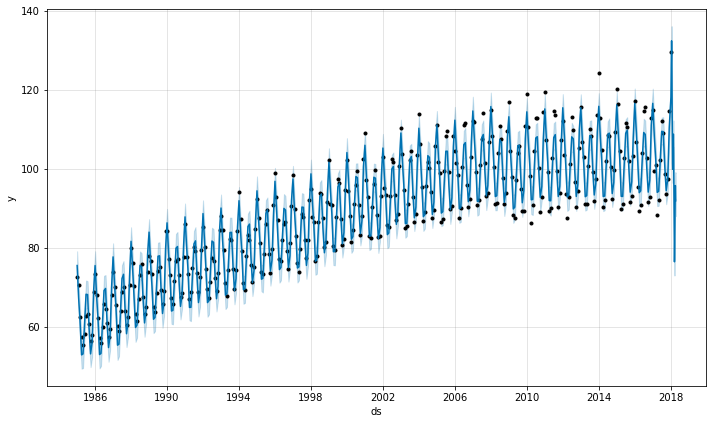

In [ ]:
model.plot(forecast_data)

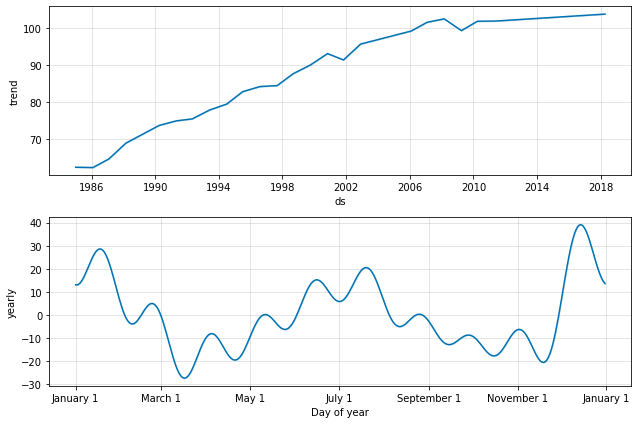

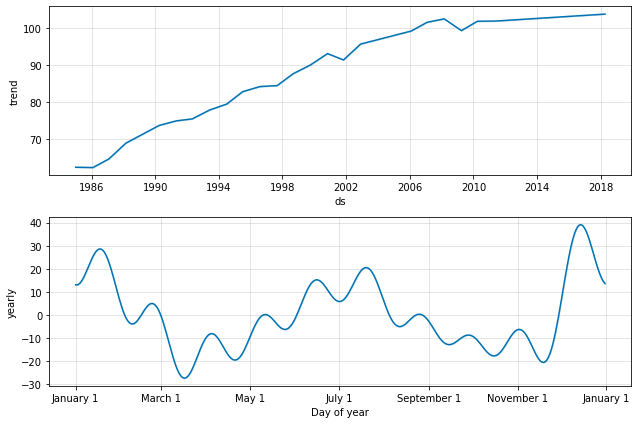

In [ ]:
model.plot_components(forecast_data)